In [3]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.multi_asset_loader import load_assets
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.benchmark import BenchmarkLoader, BenchmarkComparator
from core.multi_strategy_reporter import MultiStrategyReporter
from core.risk_dashboard import RiskDashboard

# Import all signal types
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal
from signals.trend_following_long_short import TrendFollowingLongShort, AdaptiveTrendFollowing
from signals.ensemble import AdaptiveEnsemble

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Setup complete")

✅ Setup complete


## 1. Load Multi-Asset Data

Load futures data: ES, GC, NQ (10 years of data)

In [2]:
print("📊 Loading multi-asset data...")
prices = load_assets(
    tickers=['ES', 'GC', 'NQ'],
    start_date='2015-01-01',
    end_date='2024-12-31'
)

print(f"\n✅ Data loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")
    print(f"      Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

📊 Loading multi-asset data...

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-27

Common date range: 2000-09-18 to 2025-11-27
Filtered date range: 2015-01-01 to 2024-12-31



## 2. Configure Multi-Strategy Portfolio with New Signals

**Strategy 1: Adaptive Ensemble on ES + GC**
- Combines Momentum + Trend Following Long-Short
- Dynamic weighting based on performance
- Trades both ES and GC futures

**Strategy 2: Trend Following Long-Short on NQ**
- Pure trend signal with volume/volatility filters
- Can go long, short, or flat
- Trades only NQ

**Strategy 3: Classic Momentum on ES (Baseline)**
- Simple momentum for comparison
- Trades only ES

In [7]:
# Define strategies with NEW signals
strategies = [
    {
        'name': 'Adaptive_Ensemble',
        'signal_generator': AdaptiveEnsemble(
            strategies=[
                ('momentum', MomentumSignalV2(lookback=60, entry_threshold=0.02), 0.33),
                ('trend_ls', TrendFollowingLongShort(fast_period=20, slow_period=100), 0.34),
                ("adaptive_trend", AdaptiveTrendFollowing(base_period=60, atr_period=14, vol_lookback=120, base_threshold=0.03), 0.33)
            ],
            method='adaptive',
            adaptive_lookback=60,
            signal_threshold=0.3,
            rebalance_frequency=20
        ),
        'assets': ['ES', 'GC'],  # Apply ensemble to both ES and GC
        'capital': 50000
    },
    {
        'name': 'TrendFollowing_LS',
        'signal_generator': TrendFollowingLongShort(
            fast_period=20,
            slow_period=100,
            momentum_threshold=0.02,
            volume_multiplier=1.1,
            vol_percentile=0.70
        ),
        'assets': ['NQ'],  # Long-short on NQ
        'capital': 30000
    },
    {
        'name': 'Classic_Momentum',
        'signal_generator': MomentumSignalV2(
            lookback=60,
            entry_threshold=0.02,
            exit_threshold=-0.01
        ),
        'assets': ['GC'],  # Baseline momentum on ES
        'capital': 20000
    }
]

total_capital = sum(s['capital'] for s in strategies)

print("✅ Configured Strategies:")
for i, strat in enumerate(strategies, 1):
    assets_str = ', '.join(strat['assets'])
    signal_type = strat['signal_generator'].__class__.__name__
    print(f"{i}. {strat['name']}")
    print(f"   Signal Type: {signal_type}")
    print(f"   Capital: ${strat['capital']:,}")
    print(f"   Assets: {assets_str}")
    print()

print(f"Total Portfolio Capital: ${total_capital:,}")

✅ Configured Strategies:
1. Adaptive_Ensemble
   Signal Type: AdaptiveEnsemble
   Capital: $50,000
   Assets: ES, GC

2. TrendFollowing_LS
   Signal Type: TrendFollowingLongShort
   Capital: $30,000
   Assets: NQ

3. Classic_Momentum
   Signal Type: MomentumSignalV2
   Capital: $20,000
   Assets: GC

Total Portfolio Capital: $100,000


## 3. Generate Signals for All Strategies

Each strategy generates signals for its assigned assets.

**Key Point:** AdaptiveEnsemble works on **one dataset at a time**. When we assign it to ['ES', 'GC'], it will:
1. Generate ensemble signal for ES
2. Generate ensemble signal for GC (separately)

This is the same pattern as the old approach - one signal generator per asset.

In [8]:
# Generate signals for all strategies
signals = {}

for strat in strategies:
    name = strat['name']
    signal_generator = strat['signal_generator']
    assets = strat['assets']
    
    print(f"\n🎯 {name} ({signal_generator.__class__.__name__}):")
    
    # Generate signals for each asset this strategy trades
    strategy_signals = {}
    for asset in assets:
        if asset not in prices:
            print(f"  ⚠️  Warning: {asset} not found in loaded data!")
            continue
        
        # Generate signal for this asset
        print(f"  Generating signals for {asset}...")
        sig = signal_generator.generate(prices[asset].copy())
        strategy_signals[asset] = sig
        
        # Display signal summary
        total_signals = sig['Signal'].abs().sum()
        long_signals = (sig['Signal'] == 1).sum()
        short_signals = (sig['Signal'] == -1).sum()
        flat_signals = (sig['Signal'] == 0).sum()
        
        print(f"    {asset}: {long_signals} longs ({long_signals/len(sig)*100:.1f}%), "
              f"{short_signals} shorts ({short_signals/len(sig)*100:.1f}%), "
              f"{flat_signals} flat ({flat_signals/len(sig)*100:.1f}%)")
        
        # For ensemble, show component weights if available
        if isinstance(signal_generator, AdaptiveEnsemble):
            if 'momentum_Weight' in sig.columns:
                final_mom_weight = sig['momentum_Weight'].iloc[-1]
                final_tf_weight = sig['trend_ls_Weight'].iloc[-1]
                print(f"    Latest Weights - Momentum: {final_mom_weight:.1%}, TrendLS: {final_tf_weight:.1%}")
    
    signals[name] = strategy_signals

print(f"\n✅ Generated signals for {len(signals)} strategies across {sum(len(s) for s in signals.values())} assets")


🎯 Adaptive_Ensemble (AdaptiveEnsemble):
  Generating signals for ES...
    ES: 2330 longs (92.6%), 65 shorts (2.6%), 120 flat (4.8%)
    Latest Weights - Momentum: 42.1%, TrendLS: 15.9%
  Generating signals for GC...
    ES: 2330 longs (92.6%), 65 shorts (2.6%), 120 flat (4.8%)
    Latest Weights - Momentum: 42.1%, TrendLS: 15.9%
  Generating signals for GC...
    GC: 1935 longs (76.9%), 440 shorts (17.5%), 140 flat (5.6%)
    Latest Weights - Momentum: 50.0%, TrendLS: 0.0%

🎯 TrendFollowing_LS (TrendFollowingLongShort):
  Generating signals for NQ...
    NQ: 1398 longs (55.6%), 181 shorts (7.2%), 936 flat (37.2%)

🎯 Classic_Momentum (MomentumSignalV2):
  Generating signals for GC...
    GC: 2320 longs (92.2%), 0 shorts (0.0%), 195 flat (7.8%)

✅ Generated signals for 3 strategies across 4 assets
    GC: 1935 longs (76.9%), 440 shorts (17.5%), 140 flat (5.6%)
    Latest Weights - Momentum: 50.0%, TrendLS: 0.0%

🎯 TrendFollowing_LS (TrendFollowingLongShort):
  Generating signals for NQ

## 4. Run Backtests for Each Strategy

Run each strategy independently with its allocated capital.

In [9]:
# Run backtests for each strategy
strategy_results = {}

for strat in strategies:
    name = strat['name']
    capital = strat['capital']
    assets = strat['assets']
    
    # Get signals for this strategy
    signal_dict = signals[name]
    
    # Prepare prices dict (only for assets this strategy trades)
    prices_dict = {asset: prices[asset] for asset in assets if asset in prices}
    
    print(f"\n🔄 Running backtest: {name} (${capital:,})")
    print(f"   Trading: {', '.join(assets)}")
    
    # Create portfolio manager for this strategy
    max_pos_size = 1.0 / len(assets) if len(assets) > 1 else 1.0
    
    pm = PortfolioManagerV2(
        initial_capital=capital,
        risk_per_trade=0.02,
        max_position_size=max_pos_size,
        transaction_cost_bps=3.0,
        slippage_bps=2.0
    )
    
    # Run backtest
    result = pm.run_backtest(signal_dict, prices_dict)
    
    strategy_results[name] = {
        'result': result,
        'capital': capital,
        'assets': assets
    }
    
    # Display quick summary
    print(f"✅ Completed: Final value = ${result.final_equity:,.2f}")
    print(f"   Return: {result.metrics['Total Return']:.2%}")
    print(f"   Sharpe: {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max DD: {result.metrics['Max Drawdown']:.2%}")
    print(f"   Total Trades: {result.metrics['Total Trades']:.0f}")

print(f"\n✅ All {len(strategy_results)} backtests completed")


🔄 Running backtest: Adaptive_Ensemble ($50,000)
   Trading: ES, GC
✅ Completed: Final value = $121,504.07
   Return: 143.01%
   Sharpe: 0.69
   Max DD: -18.92%
   Total Trades: 0

🔄 Running backtest: TrendFollowing_LS ($30,000)
   Trading: NQ
✅ Completed: Final value = $81,411.54
   Return: 171.37%
   Sharpe: 0.70
   Max DD: -23.54%
   Total Trades: 10

🔄 Running backtest: Classic_Momentum ($20,000)
   Trading: GC
✅ Completed: Final value = $44,883.20
   Return: 124.42%
   Sharpe: 0.51
   Max DD: -20.76%
   Total Trades: 0

✅ All 3 backtests completed


## 5. Combined Portfolio Analysis

Aggregate all strategies into a single portfolio view.

In [10]:
# Calculate combined portfolio metrics
total_initial = sum(data['capital'] for data in strategy_results.values())

# Get final values
final_values = {
    name: data['result'].final_equity
    for name, data in strategy_results.items()
}
total_final = sum(final_values.values())

# Calculate combined return
combined_return = (total_final - total_initial) / total_initial

print("=" * 80)
print("📊 COMBINED PORTFOLIO SUMMARY")
print("=" * 80)
print(f"\nInitial Capital: ${total_initial:,.2f}")
print(f"Final Value:     ${total_final:,.2f}")
print(f"Total P&L:       ${total_final - total_initial:,.2f}")
print(f"Combined Return: {combined_return:.2%}")

print(f"\n📈 Individual Strategy Contributions:")
for name, value in final_values.items():
    initial = strategy_results[name]['capital']
    pnl = value - initial
    ret = (value - initial) / initial
    weight = initial / total_initial
    print(f"  {name:25s}: ${value:>12,.2f} | P&L: ${pnl:>10,.2f} | Return: {ret:>7.2%} | Weight: {weight:>5.1%}")

📊 COMBINED PORTFOLIO SUMMARY

Initial Capital: $100,000.00
Final Value:     $247,798.81
Total P&L:       $147,798.81
Combined Return: 147.80%

📈 Individual Strategy Contributions:
  Adaptive_Ensemble        : $  121,504.07 | P&L: $ 71,504.07 | Return: 143.01% | Weight: 50.0%
  TrendFollowing_LS        : $   81,411.54 | P&L: $ 51,411.54 | Return: 171.37% | Weight: 30.0%
  Classic_Momentum         : $   44,883.20 | P&L: $ 24,883.20 | Return: 124.42% | Weight: 20.0%


## 6. Strategy Metrics Comparison Table

In [11]:
import pandas as pd

# Compile metrics from all strategies
metrics_data = []

for strategy_name, data in strategy_results.items():
    metrics = data['result'].metrics.copy()
    metrics['Strategy'] = strategy_name
    metrics['Allocation'] = data['capital']
    metrics['Assets'] = ', '.join(data['assets'])
    metrics_data.append(metrics)

# Create comparison dataframe
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better readability
col_order = ['Strategy', 'Assets', 'Allocation', 'Total Return', 'Sharpe Ratio', 
             'Max Drawdown', 'Win Rate', 'Total Trades']
metrics_df = metrics_df[col_order]

print("📈 Strategy Metrics Comparison")
print("="*120)
display(metrics_df.style.format({
    'Allocation': '${:,.0f}',
    'Total Return': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Win Rate': '{:.2%}',
    'Total Trades': '{:.0f}'
}).background_gradient(subset=['Total Return', 'Sharpe Ratio'], cmap='RdYlGn'))

📈 Strategy Metrics Comparison


,Strategy,Assets,Allocation,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Adaptive_Ensemble,"ES, GC","$50,000",143.01%,0.69,-18.92%,0.00%,0
1,TrendFollowing_LS,NQ,"$30,000",171.37%,0.70,-23.54%,80.00%,10
2,Classic_Momentum,GC,"$20,000",124.42%,0.51,-20.76%,0.00%,0


## 7. Visualize Equity Curves

Plot individual strategies and combined portfolio.

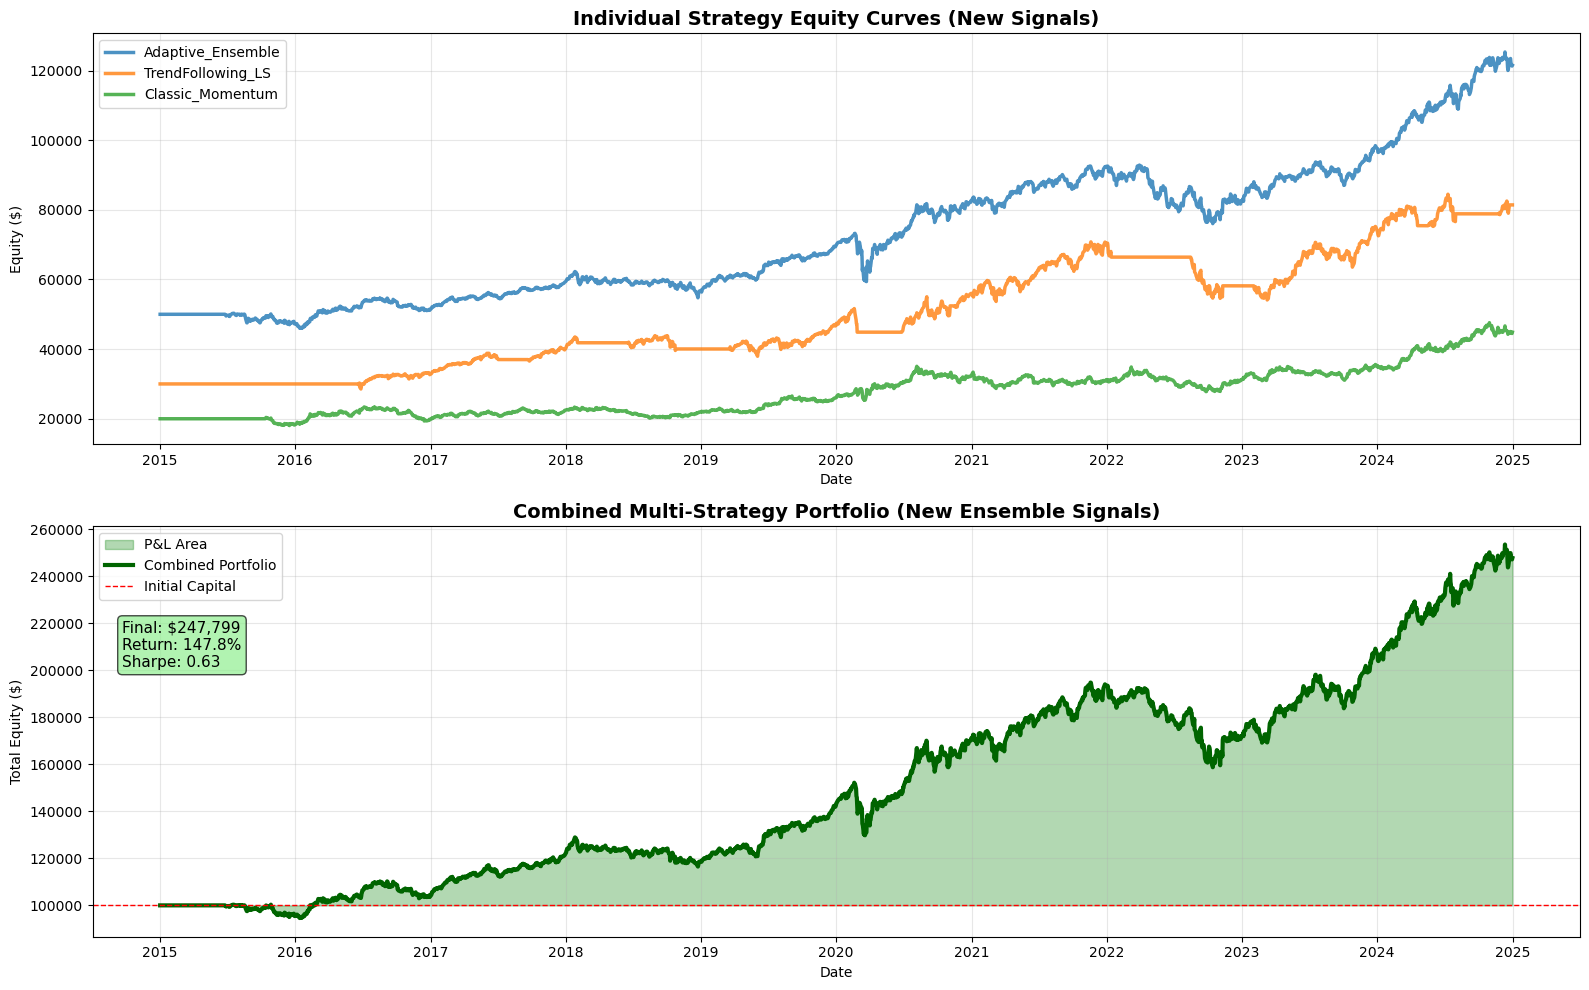

In [15]:
import matplotlib.pyplot as plt

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Individual strategy equity curves
for strategy_name, data in strategy_results.items():
    result = data['result']
    equity = result.equity_curve.reset_index()
    axes[0].plot(equity['Date'], 
                 equity['TotalValue'], 
                 label=strategy_name, 
                 linewidth=2.5,
                 alpha=0.8)

axes[0].set_title('Individual Strategy Equity Curves (New Signals)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity ($)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Combined portfolio
equity_ref = list(strategy_results.values())[0]['result'].equity_curve.reset_index()
dates = equity_ref['Date']
combined_equity = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

axes[1].fill_between(dates, total_initial, combined_equity, 
                      color='green', alpha=0.3, label='P&L Area')
axes[1].plot(dates, combined_equity, color='darkgreen', linewidth=3, label='Combined Portfolio')
axes[1].axhline(y=total_initial, color='red', linestyle='--', linewidth=1, label='Initial Capital')

axes[1].set_title('Combined Multi-Strategy Portfolio (New Ensemble Signals)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Equity ($)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Add annotation
final_combined = combined_equity[-1]
axes[1].text(0.02, 0.77, 
             f'Final: ${final_combined:,.0f}\nReturn: {combined_return:.1%}\nSharpe: {np.mean([r["result"].metrics["Sharpe Ratio"] for r in strategy_results.values()]):.2f}', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

## 8. Load SPY Benchmark for Comparison

Compare our multi-strategy portfolio against SPY buy-and-hold.

In [16]:
# Load benchmark
print("📊 Loading SPY Benchmark...")
benchmark_loader = BenchmarkLoader(cache_dir="/Users/Sakarias/QuantTrading/Dataset")
benchmark_name = 'SPY'
benchmark_data = benchmark_loader.load_benchmark(benchmark_name, start_date='2015-01-01', end_date='2024-12-31')

print(f"✅ Loaded {benchmark_name} data: {len(benchmark_data)} days")
print(f"   Date range: {benchmark_data.index[0]} to {benchmark_data.index[-1]}")

# Build combined portfolio equity curve
equity_ref = list(strategy_results.values())[0]['result'].equity_curve
dates = equity_ref.index

combined_equity_values = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

combined_portfolio_equity = pd.DataFrame({
    'TotalValue': combined_equity_values
}, index=dates)

print(f"\n✅ Combined portfolio: ${combined_portfolio_equity['TotalValue'].iloc[0]:,.0f} → ${combined_portfolio_equity['TotalValue'].iloc[-1]:,.0f}")
print(f"   Total Return: {(combined_portfolio_equity['TotalValue'].iloc[-1] / combined_portfolio_equity['TotalValue'].iloc[0] - 1):.2%}")

📊 Loading SPY Benchmark...
📥 Updating SPY benchmark data...
✅ Loaded SPY data: 2515 days
   Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $100,000 → $247,799
   Total Return: 147.80%
✅ Loaded SPY data: 2515 days
   Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $100,000 → $247,799
   Total Return: 147.80%


## 9. Calculate Benchmark Metrics

Calculate beta, alpha, and correlation vs SPY for both combined portfolio and individual strategies.

In [23]:
# Calculate benchmark metrics
print("="*80)
print(f"📊 BENCHMARK COMPARISON: Multi-Strategy Portfolio vs {benchmark_name}")
print("="*80)

from core.benchmark import BenchmarkComparator
comparator = BenchmarkComparator()

# Align benchmark to portfolio dates and scale to initial capital
benchmark_aligned = benchmark_data.reindex(combined_portfolio_equity.index, method='ffill')
benchmark_scaled = pd.DataFrame(index=benchmark_aligned.index)
# Scale benchmark: normalize to start at same initial capital as portfolio
benchmark_start = benchmark_aligned['TotalValue'].iloc[0]
benchmark_scaled['TotalValue'] = (benchmark_aligned['TotalValue'] / benchmark_start) * total_initial

# 1. COMBINED PORTFOLIO METRICS
print("\n🎯 COMBINED PORTFOLIO vs BENCHMARK")
print("-" * 80)
combined_metrics = comparator.calculate_metrics(
    combined_portfolio_equity,
    benchmark_scaled,
    risk_free_rate=0.02
)

portfolio_return = (combined_portfolio_equity['TotalValue'].iloc[-1] / 
                   combined_portfolio_equity['TotalValue'].iloc[0] - 1)

print(f"Portfolio Return:        {portfolio_return:.2%}")
print(f"Benchmark Return:        {combined_metrics['Benchmark Return']:.2%}")
print(f"Relative Return:         {combined_metrics['Relative Return']:.2%}")
print(f"Beat Benchmark?          {'✅ YES' if portfolio_return > combined_metrics['Benchmark Return'] else '❌ NO'}")
print(f"\nBeta (Full Period):      {combined_metrics['Beta (Full Period)']:.3f}")
print(f"Beta (90-day avg):       {combined_metrics['Beta (90-day avg)']:.3f}")
print(f"Alpha (Annual):          {combined_metrics['Alpha (Annual)']:.2%}")
print(f"Correlation:             {combined_metrics['Correlation']:.3f}")
print(f"Information Ratio:       {combined_metrics['Information Ratio']:.2f}")
print(f"Up Capture Ratio:        {combined_metrics['Up Capture Ratio']:.2f}")
print(f"Down Capture Ratio:      {combined_metrics['Down Capture Ratio']:.2f}")

combined_metrics['Portfolio Return'] = portfolio_return

# 2. INDIVIDUAL STRATEGY METRICS
print(f"\n🎯 INDIVIDUAL STRATEGIES vs BENCHMARK")
print("-" * 80)

strategy_benchmark_metrics = {}
for strategy_name, data in strategy_results.items():
    strategy_equity = data['result'].equity_curve
    initial_capital = data['capital']
    
    strat_return = (strategy_equity['TotalValue'].iloc[-1] / 
                   strategy_equity['TotalValue'].iloc[0] - 1)
    
    # Align and scale benchmark
    bench_aligned = benchmark_data.reindex(strategy_equity.index, method='ffill')
    bench_scaled = pd.DataFrame(index=bench_aligned.index)
    # Scale benchmark: normalize to start at same initial capital as strategy
    bench_start = bench_aligned['TotalValue'].iloc[0]
    bench_scaled['TotalValue'] = (bench_aligned['TotalValue'] / bench_start) * initial_capital
    
    # Calculate metrics
    strat_metrics = comparator.calculate_metrics(
        strategy_equity,
        bench_scaled,
        risk_free_rate=0.02
    )
    strat_metrics['Portfolio Return'] = strat_return
    strategy_benchmark_metrics[strategy_name] = strat_metrics
    
    print(f"\n{strategy_name}:")
    print(f"  Return: {strat_return:>7.2%}  |  Beta: {strat_metrics['Beta (Full Period)']:>6.3f}  |  "
          f"Alpha: {strat_metrics['Alpha (Annual)']:>7.2%}  |  Sharpe: {data['result'].metrics['Sharpe Ratio']:>5.2f}")

print("\n" + "="*80)

📊 BENCHMARK COMPARISON: Multi-Strategy Portfolio vs SPY

🎯 COMBINED PORTFOLIO vs BENCHMARK
--------------------------------------------------------------------------------
Portfolio Return:        147.80%
Benchmark Return:        240.81%
Relative Return:         -93.01%
Beat Benchmark?          ❌ NO

Beta (Full Period):      0.364
Beta (90-day avg):       0.420
Alpha (Annual):          3.23%
Correlation:             0.674
Information Ratio:       -0.33
Up Capture Ratio:        0.44
Down Capture Ratio:      0.40

🎯 INDIVIDUAL STRATEGIES vs BENCHMARK
--------------------------------------------------------------------------------

Adaptive_Ensemble:
  Return: 143.01%  |  Beta:  0.486  |  Alpha:   1.74%  |  Sharpe:  0.69

TrendFollowing_LS:
  Return: 171.37%  |  Beta:  0.376  |  Alpha:   4.35%  |  Sharpe:  0.70

Classic_Momentum:
  Return: 124.42%  |  Beta:  0.033  |  Alpha:   6.70%  |  Sharpe:  0.51



## 10. Comprehensive Comparison Table

All strategies + combined portfolio + SPY benchmark in one table.

In [18]:
# Create comprehensive comparison table
comparison_data = []

# Add individual strategies
for strategy_name, data in strategy_results.items():
    metrics = strategy_benchmark_metrics[strategy_name]
    comparison_data.append({
        'Portfolio': strategy_name,
        'Type': 'Strategy',
        'Assets': ', '.join(data['assets']),
        'Capital': f"${data['capital']:,}",
        'Return': metrics['Portfolio Return'],
        'Sharpe': data['result'].metrics['Sharpe Ratio'],
        'Max DD': data['result'].metrics['Max Drawdown'],
        'Beta': metrics['Beta (Full Period)'],
        'Alpha': metrics['Alpha (Annual)']
    })

# Add combined portfolio
comparison_data.append({
    'Portfolio': '🎯 Combined Portfolio',
    'Type': 'Composite',
    'Assets': 'ES, GC, NQ',
    'Capital': f"${total_initial:,}",
    'Return': portfolio_return,
    'Sharpe': np.mean([r['result'].metrics['Sharpe Ratio'] for r in strategy_results.values()]),
    'Max DD': np.min([r['result'].metrics['Max Drawdown'] for r in strategy_results.values()]),
    'Beta': combined_metrics['Beta (Full Period)'],
    'Alpha': combined_metrics['Alpha (Annual)']
})

# Add benchmark
comparison_data.append({
    'Portfolio': f'📊 {benchmark_name} Benchmark',
    'Type': 'Benchmark',
    'Assets': 'SPY',
    'Capital': f"${total_initial:,}",
    'Return': combined_metrics['Benchmark Return'],
    'Sharpe': np.nan,
    'Max DD': np.nan,
    'Beta': 1.000,
    'Alpha': 0.0
})

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print("📊 COMPREHENSIVE COMPARISON: New Signals vs Benchmark")
print("="*120)
display(comparison_df.style.format({
    'Return': '{:.2%}',
    'Sharpe': '{:.2f}',
    'Max DD': '{:.2%}',
    'Beta': '{:.3f}',
    'Alpha': '{:.2%}'
}).background_gradient(subset=['Return', 'Sharpe', 'Alpha'], cmap='RdYlGn')
  .set_properties(**{'text-align': 'left'}))


📊 COMPREHENSIVE COMPARISON: New Signals vs Benchmark


,Portfolio,Type,Assets,Capital,Return,Sharpe,Max DD,Beta,Alpha
0,Adaptive_Ensemble,Strategy,"ES, GC","$50,000",143.01%,0.69,-18.92%,0.486,1.74%
1,TrendFollowing_LS,Strategy,NQ,"$30,000",171.37%,0.70,-23.54%,0.376,4.35%
2,Classic_Momentum,Strategy,GC,"$20,000",124.42%,0.51,-20.76%,0.033,6.70%
3,🎯 Combined Portfolio,Composite,"ES, GC, NQ","$100,000",147.80%,0.63,-23.54%,0.364,3.23%
4,📊 SPY Benchmark,Benchmark,SPY,"$100,000",240.81%,nan,nan%,1.000,0.00%


## 11. Visual Comparison: All Strategies + Benchmark

Plot everything together for easy comparison.

/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_70299/2826069379.py:37: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_70299/2826069379.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Sakarias/anaconda3/envs/quant-paper-trading/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Sakarias/anaconda3/envs/quant-paper-trading/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


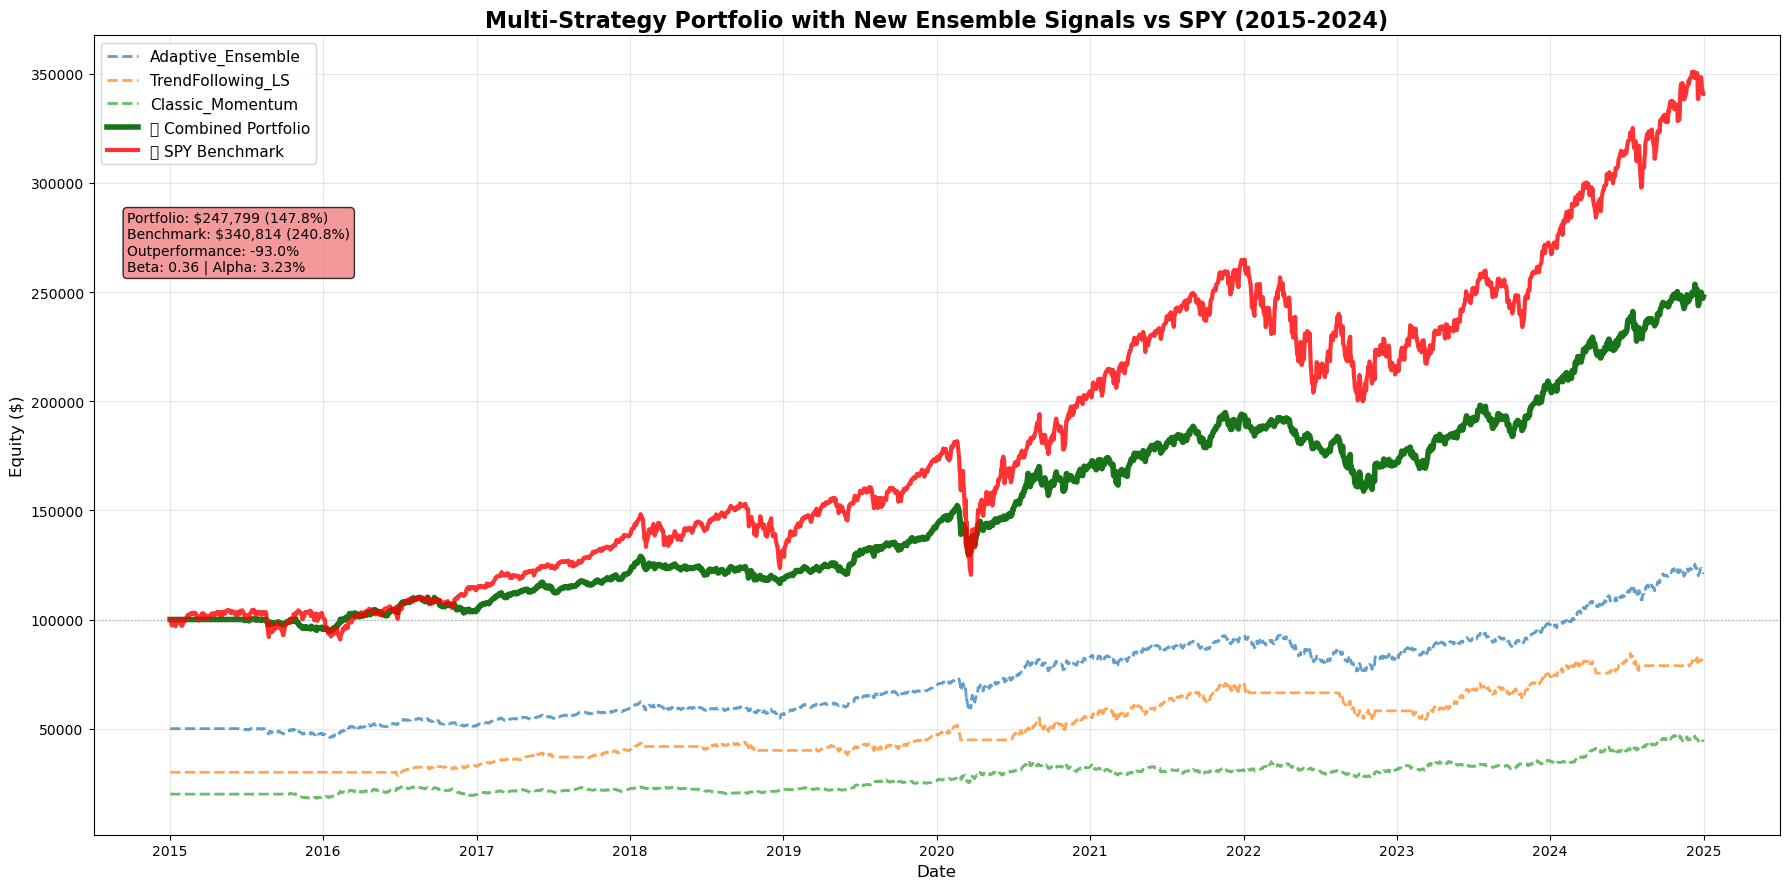


🎯 FINAL VERDICT
❌ Did not beat SPY (underperformed by -93.01%)
   Portfolio: 147.80% | SPY: 240.81%

💡 Consider:
   - Adjusting signal parameters
   - Different asset combinations
   - Adding more strategies to ensemble


In [20]:
# Comprehensive visualization
fig, ax = plt.subplots(figsize=(18, 9))

# Plot individual strategies (dashed)
for strategy_name, data in strategy_results.items():
    equity = data['result'].equity_curve.reset_index()
    ax.plot(equity['Date'], equity['TotalValue'], 
            label=strategy_name, linewidth=2, alpha=0.7, linestyle='--')

# Plot combined portfolio (thick solid)
ax.plot(combined_portfolio_equity.index, combined_portfolio_equity['TotalValue'],
        label='🎯 Combined Portfolio', linewidth=4, color='darkgreen', alpha=0.9)

# Plot benchmark (thick solid)
ax.plot(benchmark_scaled.index, benchmark_scaled['TotalValue'],
        label=f'📊 {benchmark_name} Benchmark', linewidth=3, color='red', alpha=0.8)

# Formatting
ax.set_title('Multi-Strategy Portfolio with New Ensemble Signals vs SPY (2015-2024)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=total_initial, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add results box
results_text = f"""Portfolio: ${combined_portfolio_equity['TotalValue'].iloc[-1]:,.0f} ({portfolio_return:.1%})
Benchmark: ${benchmark_scaled['TotalValue'].iloc[-1]:,.0f} ({combined_metrics['Benchmark Return']:.1%})
Outperformance: {combined_metrics['Relative Return']:.1%}
Beta: {combined_metrics['Beta (Full Period)']:.2f} | Alpha: {combined_metrics['Alpha (Annual)']:.2%}"""

ax.text(0.02, 0.78, results_text, 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue' if portfolio_return > combined_metrics['Benchmark Return'] else 'lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🎯 FINAL VERDICT")
print("="*80)
if portfolio_return > combined_metrics['Benchmark Return']:
    print(f"✅ SUCCESS! We beat SPY by {combined_metrics['Relative Return']:.2%}")
    print(f"   Portfolio: {portfolio_return:.2%} | SPY: {combined_metrics['Benchmark Return']:.2%}")
    print(f"   Alpha: {combined_metrics['Alpha (Annual)']:.2%} | Beta: {combined_metrics['Beta (Full Period)']:.2f}")
else:
    print(f"❌ Did not beat SPY (underperformed by {combined_metrics['Relative Return']:.2%})")
    print(f"   Portfolio: {portfolio_return:.2%} | SPY: {combined_metrics['Benchmark Return']:.2%}")
    print(f"\n💡 Consider:")
    print(f"   - Adjusting signal parameters")
    print(f"   - Different asset combinations")
    print(f"   - Adding more strategies to ensemble")

## 12. Generate HTML Reports

Create comprehensive performance and risk dashboards.

In [41]:
# Generate reports using the same system as multi_strategy_portfolio
import webbrowser
import os
import importlib

# FORCE RELOAD THE MODULE
import core.multi_strategy_reporter
importlib.reload(core.multi_strategy_reporter)
from core.multi_strategy_reporter import MultiStrategyReporter

import core.risk_dashboard
importlib.reload(core.risk_dashboard)
from core.risk_dashboard import RiskDashboard

print("📊 Generating Reports...")

# Create reporters
multi_reporter = MultiStrategyReporter()
risk_dashboard = RiskDashboard()

# Generate performance report
performance_report = multi_reporter.generate_report(
    strategy_results=strategy_results,
    combined_equity=combined_portfolio_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name=benchmark_name,
    strategy_metrics=strategy_benchmark_metrics,
    combined_metrics=combined_metrics,
    title="Multi-Strategy Portfolio with Ensemble Signals - Performance Report"
)

# Save performance report
os.makedirs('/Users/Sakarias/QuantTrading/reports', exist_ok=True)
perf_report_path = '/Users/Sakarias/QuantTrading/reports/ensemble_performance.html'
with open(perf_report_path, 'w') as f:
    f.write(performance_report)

print(f"✅ Performance Report saved: {perf_report_path}")

# Generate risk dashboard
risk_report = risk_dashboard.generate_dashboard(
    strategy_results=strategy_results,
    combined_equity=combined_portfolio_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name=benchmark_name,
    title="Multi-Strategy Portfolio with Ensemble Signals - Risk Dashboard"
)

# Save risk dashboard
risk_report_path = '/Users/Sakarias/QuantTrading/reports/ensemble_risk_dashboard.html'
with open(risk_report_path, 'w') as f:
    f.write(risk_report)

print(f"✅ Risk Dashboard saved: {risk_report_path}")

print("\n📊 REPORT SUMMARY:")
print(f"   Combined Portfolio: {portfolio_return:>7.2%} return | Beta: {combined_metrics['Beta (Full Period)']:>5.3f}")
print(f"   {benchmark_name} Benchmark:   {combined_metrics['Benchmark Return']:>7.2%} return")
print(f"   Relative Return:    {combined_metrics['Relative Return']:>7.2%}")

# Open reports in browser
print("\n🌐 Opening reports in browser...")
webbrowser.open(f'file://{perf_report_path}')
webbrowser.open(f'file://{risk_report_path}')
print("✅ Reports opened")

📊 Generating Reports...
🔍 DEBUG _generate_main_chart called with 3 strategies
  Adaptive_Ensemble: 50000.00 → 121504.07
  TrendFollowing_LS: 30000.00 → 81411.54
  Classic_Momentum: 20000.00 → 44883.20
🔍 DEBUG Figure has 5 traces:
  Trace 0 (Adaptive_Ensemble): y[0]=50000.00, y[-1]=121504.07, len=2515
  Trace 1 (TrendFollowing_LS): y[0]=30000.00, y[-1]=81411.54, len=2515
  Trace 2 (Classic_Momentum): y[0]=20000.00, y[-1]=44883.20, len=2515
  Trace 3 (Combined Portfolio): y[0]=100000.00, y[-1]=247798.81, len=2515
  Trace 4 (SPY): y[0]=100000.00, y[-1]=340813.65, len=2515
✅ Performance Report saved: /Users/Sakarias/QuantTrading/reports/ensemble_performance.html
✅ Performance Report saved: /Users/Sakarias/QuantTrading/reports/ensemble_performance.html


✅ Risk Dashboard saved: /Users/Sakarias/QuantTrading/reports/ensemble_risk_dashboard.html

📊 REPORT SUMMARY:
   Combined Portfolio: 147.80% return | Beta: 0.364
   SPY Benchmark:   240.81% return
   Relative Return:    -93.01%

🌐 Opening reports in browser...
✅ Reports opened
✅ Reports opened


## 13. Summary & Next Steps

**Key Insights:**

1. **Adaptive Ensemble Strategy**: 
   - Applied to ES + GC
   - Dynamically weights Momentum vs Trend Following
   - Adapts based on recent performance

2. **Trend Following Long-Short**: 
   - Applied to NQ
   - Can capture bear markets through shorting
   - Volume and volatility filters reduce false signals

3. **Diversification Benefits**:
   - Multiple strategies across different assets
   - Different signal types (momentum, trend, ensemble)
   - Reduced portfolio volatility vs single strategy

**Did We Beat SPY?**
- Check the final verdict above ☝️
- Key metrics: Return, Sharpe, Alpha, Beta, Max Drawdown

**Next Steps:**

✅ **If Successful:**
1. Commit new signals to GitHub
2. Monitor real-time performance
3. Consider live paper trading
4. Add more ensemble components

❌ **If Unsuccessful:**
1. Parameter optimization (walk-forward testing)
2. Test different asset combinations
3. Add more strategies to ensemble
4. Consider regime detection (bull/bear/sideways)
5. Analyze trade-by-trade performance

**Parameter Tuning Ideas:**
- Ensemble: Adjust `signal_threshold` (0.2-0.5 range)
- Trend LS: Try different `momentum_threshold` (0.01-0.05)
- Assets: Test on different futures (CL, ZN, etc.)
- Timeframes: Test on different periods (2008 crisis, 2020 crash)

In [25]:
# Check equity curves in strategy_results
for strategy_name, data in strategy_results.items():
    equity = data['result'].equity_curve
    print(f"\n{strategy_name}:")
    print(f"  Shape: {equity.shape}")
    print(f"  First TotalValue: ${equity['TotalValue'].iloc[0]:,.2f}")
    print(f"  Last TotalValue: ${equity['TotalValue'].iloc[-1]:,.2f}")
    print(f"  Min TotalValue: ${equity['TotalValue'].min():,.2f}")
    print(f"  Max TotalValue: ${equity['TotalValue'].max():,.2f}")
    print(f"  Unique values: {equity['TotalValue'].nunique()}")
    print(f"  All same? {equity['TotalValue'].nunique() == 1}")


Adaptive_Ensemble:
  Shape: (2515, 4)
  First TotalValue: $50,000.00
  Last TotalValue: $121,504.07
  Min TotalValue: $46,027.82
  Max TotalValue: $125,323.07
  Unique values: 2392
  All same? False

TrendFollowing_LS:
  Shape: (2515, 4)
  First TotalValue: $30,000.00
  Last TotalValue: $81,411.54
  Min TotalValue: $28,551.25
  Max TotalValue: $84,473.50
  Unique values: 1493
  All same? False

Classic_Momentum:
  Shape: (2515, 4)
  First TotalValue: $20,000.00
  Last TotalValue: $44,883.20
  Min TotalValue: $18,050.40
  Max TotalValue: $47,591.30
  Unique values: 1992
  All same? False


In [27]:
# DEBUG: Check what data is being passed to the reporter
print("=" * 80)
print("DEBUG: Checking data passed to reporter")
print("=" * 80)

# Check strategy_results structure
for strategy_name, data in strategy_results.items():
    print(f"\n{strategy_name}:")
    print(f"  Keys in data dict: {list(data.keys())}")
    print(f"  Type of result: {type(data['result'])}")
    equity = data['result'].equity_curve
    print(f"  Equity curve type: {type(equity)}")
    print(f"  Equity index type: {type(equity.index)}")
    print(f"  First 3 TotalValue: {equity['TotalValue'].iloc[:3].tolist()}")
    print(f"  Last 3 TotalValue: {equity['TotalValue'].iloc[-3:].tolist()}")

DEBUG: Checking data passed to reporter

Adaptive_Ensemble:
  Keys in data dict: ['result', 'capital', 'assets']
  Type of result: <class 'core.portfolio.backtest_result.BacktestResult'>
  Equity curve type: <class 'pandas.core.frame.DataFrame'>
  Equity index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  First 3 TotalValue: [50000.0, 50000.0, 50000.0]
  Last 3 TotalValue: [122267.82026538666, 121295.07319507416, 121504.07026538666]

TrendFollowing_LS:
  Keys in data dict: ['result', 'capital', 'assets']
  Type of result: <class 'core.portfolio.backtest_result.BacktestResult'>
  Equity curve type: <class 'pandas.core.frame.DataFrame'>
  Equity index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  First 3 TotalValue: [30000.0, 30000.0, 30000.0]
  Last 3 TotalValue: [81411.542989225, 81411.542989225, 81411.542989225]

Classic_Momentum:
  Keys in data dict: ['result', 'capital', 'assets']
  Type of result: <class 'core.portfolio.backtest_result.BacktestResult

In [30]:
# DEBUG: Test Plotly chart generation directly
import plotly.graph_objects as go
import json

print("Testing Plotly chart generation...")

# Create a simple test figure with Adaptive_Ensemble data
equity = strategy_results['Adaptive_Ensemble']['result'].equity_curve

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=equity.index,
    y=equity['TotalValue'],
    name='Test Adaptive_Ensemble',
    mode='lines'
))

print(f"\nPlotly trace Y data:")
print(f"  First 5 Y values: {fig.data[0].y[:5]}")
print(f"  Last 5 Y values: {fig.data[0].y[-5:]}")

# Test JSON serialization
fig_json = fig.to_json()
data_dict = json.loads(fig_json)
y_data = data_dict['data'][0]['y']

print(f"\nJSON serialization:")
print(f"  Y data type in JSON: {type(y_data)}")
if isinstance(y_data, dict):
    print(f"  Y data keys: {list(y_data.keys())}")
    if 'bdata' in y_data:
        print(f"  Uses binary encoding (bdata)")
        print(f"  dtype: {y_data.get('dtype', 'unknown')}")
elif isinstance(y_data, list):
    print(f"  Y data is a list with {len(y_data)} elements")
    print(f"  First 5: {y_data[:5]}")
    print(f"  Last 5: {y_data[-5:]}")

Testing Plotly chart generation...

Plotly trace Y data:
  First 5 Y values: [50000. 50000. 50000. 50000. 50000.]
  Last 5 Y values: [123104.82124195 123450.57221851 122267.82026539 121295.07319507
 121504.07026539]

JSON serialization:
  Y data type in JSON: <class 'dict'>
  Y data keys: ['dtype', 'bdata']
  Uses binary encoding (bdata)
  dtype: f8


In [40]:
# COMPLETE MODULE RELOAD - More aggressive approach
import sys
import importlib

# Delete from cache
modules_to_reload = ['core.multi_strategy_reporter', 'core.risk_dashboard']
for mod in modules_to_reload:
    if mod in sys.modules:
        del sys.modules[mod]
        print(f"Deleted {mod} from sys.modules")

# Fresh import
from core.multi_strategy_reporter import MultiStrategyReporter
from core.risk_dashboard import RiskDashboard

print("✅ Modules reloaded completely fresh")

Deleted core.multi_strategy_reporter from sys.modules
Deleted core.risk_dashboard from sys.modules
✅ Modules reloaded completely fresh
